# ML CUP 2022 #

## Grid search with PyTorch ##

this notebook creates a neural network using the framework PyTorch to generalize the problem of the ML cup 2022. it searches the best combination of hyperparameters performing a  nested grid search over a given range of values. Below there is a brief account about the implementation of the neural network.

hyperparameters considered for the grid search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layers
4. the lambda coefficient for lasso regularisation (L1)

Model created using early stopping.\
Model selection performed using a cross validation.\
The model assessment phase in not included in this notebook

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

import numpy as np
import math
import sys
import os
import itertools
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

from multiprocessing import Process
from multiprocessing import Queue

create reproducible results

In [2]:
seed = 2
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

this class has been used to denormalize the final result

In [3]:
class DeNormalizer:
    def __init__(self):
        self.target1 = None
        self.target2 = None
        
    # save the max min values for a target
    def setTargetMinMax(self, min_max_values, target):
        if (target == 1):
            self.target1 = min_max_values
        elif(target == 2):
            self.target2 = min_max_values
        else:
            print("warning, error")
    
    # denormalize the dataset
    def deNormalize(self, data, target):
        min_max_values = [None, None]
        if (target == 1):
            min_max_values = self.target1
        elif (target == 2):
            min_max_values = self.target2
        else:
            print("warning, error")
            
        denorm_data = data * (min_max_values[1] - min_max_values[0]) + min_max_values[0]
        return denorm_data

We used the function below to normalize our training set (both input and target) according to a min-max normalization

In [4]:
def min_max_normalizer(x_data, y_data):
    
    x_cols = len(x_data[0])
    
    # normalize the input
    for i in range(x_cols):
        col = x_data[:, i]
        max_vl = np.amax(col)
        min_vl = np.amin(col)
        
        x_data[:, i] = (x_data[:, i] - min_vl) / (max_vl - min_vl)
        
        
    y_cols = len(y_data[0])
    
    # object used later to denormalize our data
    deNormalizer = DeNormalizer()
        
    # normalize the target
    for i in range(y_cols):
        col = y_data[:, i]
        max_vl = np.amax(col)
        min_vl = np.amin(col)
        
        y_data[:, i] = (y_data[:, i] - min_vl) / (max_vl - min_vl)
        
        # save the min max values (to denormalize later)
        target_min_max = [min_vl, max_vl]
        deNormalizer.setTargetMinMax(target_min_max, i+1)
        
    
    return x_data, y_data, deNormalizer

function to load the (normalized) training set for the ml cup

In [5]:
def load_mlcup_dataset(local_path):

    # Load the dataset
    data = np.loadtxt(local_path, delimiter=",", skiprows=1, usecols=range(2,13), dtype='float32')

    # shuffle the input
    data = shuffle(data) 

    # divide into input and target
    x_data = (data[:, 0:9])
    y_data = (data[:, 9:11])
    
    # min_max normalize input and target
    x_data, y_data, deNormalizer = min_max_normalizer(x_data, y_data) 

    # recreate the design set
    data = np.concatenate((x_data, y_data), axis = 1) 
    
    return data, deNormalizer

the class CupDataset has been used to create a valid dataset (for the ML cup) for the neural network

In [40]:
#Loading the ML cup's dataset
class CupDataset(Dataset):
    
    def __init__(self, data):
        # division between training and validation
        data_x = (data[:, 0:9])
        data_y = (data[:, 9:11])
                
        # conversion from numpy array to tensor
        self.x = torch.from_numpy(data_x)
        self.y = torch.from_numpy(data_y)
        
        # convert to float32
        self.x = self.x.to(torch.float32)
        self.y = self.y.to(torch.float32)
        
        # save the number of patterns in the training/validation set
        self.n_samples = data_x.shape[0]
        
    # return a specific tensor
    def __getitem__ (self, index):
        return self.x[index], self.y[index]
    
    # return the total number of patterns
    def __len__(self):
        return self.n_samples

The class CupNeuralNet outlines the structure of the neural network

In [7]:
class CupNeuralNet(nn.Module):
    # define the neural network's structure
    def __init__(self, input_size, hidden_size, num_output):
        super(CupNeuralNet, self).__init__()
        self.hl = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.ol = nn.Linear(hidden_size, output_size)
        
    # Forward pass of the neural network
    def forward(self, x):
        out = self.hl(x)
        out = self.relu(out)
        out = self.ol(out)
        return out

The class EarlyStopper has been used to implement early stopping

In [8]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        # lowest error on the validation set ever reached
        self.min_validation_loss = np.inf
        
    # call this method at the end of each epoch, to check wheter the loss on the validation set decreased or not
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.counter = 0
            self.min_validation_loss = validation_loss
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

The function below train a model given a training set, a validation set, and a proper dictionary of hyper parameters. It returns the final score on the validation set

In [9]:
def trial_model_construction(
    dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, 
    total_samples_tr, total_samples_vl, num_epochs, verbose
):
      
    # list of hyperparameters
    hidden_size = None
    learning_rate = None
    momentum = None
    ridge_lambda = None
    
    # retrieve the combination of hyperparameters from the dictionary
    try:
        hidden_size = hyper_parameters['hidden_size']
    except:
        print("hidden_size not passed")
        hidden_size = 1
    try:
        learning_rate = hyper_parameters['learning_rate']
    except:
        print("learning rate not passed")
        learning_rate = 0.1
    try:
        momentum = hyper_parameters['momentum']
    except:
        print("momentum not passed")
        momentum = 0.3
    try:
        ridge_lambda = hyper_parameters['ridge_lambda']
    except:
        print("ridge lambda not passed")
        ridge_lambda = 0.0
    
    
    # initialize the model and the optimizer
    model = CupNeuralNet(input_size, hidden_size, output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=ridge_lambda)
    criterion = nn.MSELoss()
    
    # save the final Euclidean distance on the validation set
    val_mean_euclidean_distance = None

    # execute early stopping (patience = 10)
    early_stopper = EarlyStopper(patience=10)
    for epoch in range(num_epochs):
        
        #training loop
        model.train()
        euclidean_distance = 0
        batch_loss = 0
        for i, (inputs, labels) in enumerate(dataloader_tr):

            # forward pass
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the mean euclidean distance
            euclidean_distance += (outputs - labels).pow(2).sum(1).sqrt().sum()
            
            # compute the loss on the training set
            batch_loss += loss.item() * inputs.size(0)


        #validation loop
        model.eval()
        val_euclidean_distance = 0
        val_batch_loss = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader_vl):

                # evaluate the performance of the model on the validation set
                inputs = inputs.to(torch.float32)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # compute the mean euclidean distance
                val_euclidean_distance += (outputs - labels).pow(2).sum(1).sqrt().sum()
                
                # compute the loss on the training set
                val_batch_loss += loss.item() * inputs.size(0)


        # compute the final mean Euclidean distance on both training set and validation set
        mean_euclidean_distance = euclidean_distance / total_samples_tr
        val_mean_euclidean_distance = val_euclidean_distance / total_samples_vl
    
        # compute the average loss on both training set and validation set
        epoch_loss =  batch_loss / total_samples_tr # len(dataloader_tr.sampler)
        val_epoch_loss = batch_loss / total_samples_vl # len(dataloader_vl.sampler)

        # look if condition for early stopping is satisfied
        es = early_stopper.early_stop(val_epoch_loss)
        if es:
            if verbose == 2:
                print("condition for early stopping is satisfied")
            break

        if verbose == 2:
            print(
                "epoch n. ", epoch, "euclidean_distance", mean_euclidean_distance.item(), "val_euclidean_distance", val_mean_euclidean_distance.item(),
                "loss", epoch_loss, "val_loss", val_epoch_loss
            )
        
        
    #return the final accuracy on the validation set
    return val_mean_euclidean_distance.item()

The function execute_different_trials return the average score obtained by building different models with the same training set, validation set and hyperparameters

In [10]:
def average(lst):
    return sum(lst) / len(lst)

def execute_different_trials(
    dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, n_trials, 
    total_samples_tr, total_samples_vl, num_epochs, verbose
):
    
    score_list = []
    for i in range(n_trials):
        
        score = trial_model_construction(
            dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters,
            total_samples_tr, total_samples_vl, num_epochs, verbose
        )
        
        score_list.append(score)
    
    return average(score_list)

the function cross_validation_trials implement the cross validation to find the best combination of hyperparameters

In [11]:
def cross_validation_trials(
    training_set, input_size, output_size, hyper_parameters, n_trials,
    num_epochs, n_kfolds, batch_size, verbose
):
    score_list = []
    # creation of the kfolds for the cross validation
    cross_partitions = model_selection.KFold(n_kfolds)
    for train_indices, valid_indices  in cross_partitions.split(training_set):
        # division into training set and validation
        cv_train, cv_val = training_set[train_indices], training_set[valid_indices]
        
        # compute number of patterns in both training set and validation set
        total_samples_tr = len(cv_train)
        total_samples_vl = len(cv_val)
        
        # create a pytorch dataloader for the training set
        dataset_tr = CupDataset(cv_train)
        dataloader_tr = DataLoader(dataset=dataset_tr, batch_size=batch_size, shuffle=True)

        # create a pytorch dataloader for the validation set
        dataset_vl = CupDataset(cv_val)
        dataloader_vl = DataLoader(dataset=dataset_vl, batch_size=len(cv_val))
        
        # retrieve the final score
        score = execute_different_trials(
            dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, n_trials, 
            total_samples_tr, total_samples_vl, num_epochs, verbose
        )
        
        score_list.append(score)
    
    final_score = average(score_list)
    
    if verbose == 1 or verbose == 2:
        output = "score: "
        output += str(final_score)
        output += ", hyperparameters: "
        for i in hyper_parameters:
            output += "("
            output += i
            output += " = "
            output += str(hyper_parameters[i])
            output += ") "
        print(output)
        
    return final_score

Define the cartesian product among the hyperparameters

In [12]:
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

The function below define the grid search for the model selection phase

In [13]:
def grid_search_process(
    training_set, input_size, output_size, hyper_parameters, n_trials, num_epochs, n_kfolds,
    batch_size, verbose, total_process, num_pr, isMax, shared_queue
):
    # save the best score and set of hyperparameters found by the process
    best_score = None
    best_comb = None
    if isMax:
        best_score = sys.float_info.min
    else:
        best_score = sys.float_info.max
    
    # try all the possible combinations
    for i in range(num_pr, len(hyper_parameters), total_process):
        score = cross_validation_trials(
            training_set, input_size, output_size, hyper_parameters[i], n_trials,
            num_epochs, n_kfolds, batch_size, verbose
        )
        
        if isMax:
            if score > best_score:
                best_score = score
                best_comb = hyper_parameters[i]
        else:
            if score < best_score:
                best_score = score
                best_comb = hyper_parameters[i]
                
    
    # put the best local score and hp in the queue shared among the processes
    shared_queue.put([best_score, best_comb])

below there is the function which implement the grid search over a combination of hyperparameters

In [14]:
# perform a grid search over a dictionary of hyperparameters
def grid_search(
    training_set, input_size, output_size, hyper_parameters, n_trials, num_epochs, n_kfolds,
    batch_size=16, verbose=0, total_process=1, isMax=True
):
    # compute cartesian product among all the hyperparameterss
    cart_prod = makeGrid(hyper_parameters)
    
    # list of threads
    processes = [None]*total_process

    # queue containing the best pairs (score, hyperparameters) for each process
    shared_queue = Queue()
    
    
    for i in range(total_process):
        processes[i] = Process(
            target=grid_search_process,
            args=(training_set, input_size, output_size, cart_prod, n_trials, num_epochs, n_kfolds,
                  batch_size, verbose, total_process, i, isMax, shared_queue)
        )
    
    # wait the execution of the threads
    for pr in processes:
        pr.start()
    
    # join and return the final value of each thread
    for i in range(len(processes)):
        processes[i].join()
        
    
    # find the best global score (among all the processes)
    best_global_score = None
    best_global_hp_comb = None
    
    if isMax:
        best_global_score = sys.float_info.min
        while not shared_queue.empty():
            pair = shared_queue.get()
            if best_global_score < pair[0]:
                best_global_score = pair[0]
                best_global_hp_comb = pair[1]
    else:
        best_global_score = sys.float_info.max
        while not shared_queue.empty():
            pair = shared_queue.get()
            if best_global_score > pair[0]:
                best_global_score = pair[0]
                best_global_hp_comb = pair[1]
            
    print(
        'best score', best_global_score,
        'best combination of hyper parameters', best_global_hp_comb
    )
    
    return best_global_score, best_global_hp_comb

function to divide the design set into training set and validation

In [15]:
def validation_split(design_set, perc_split):
    
    # division between training set and validation set
    subset_size = int(perc_split * len(design_set))

    index = np.random.choice(len(design_set), subset_size, replace=False)
    index = np.sort(index)

    validation_set = design_set[index]

    training_set = np.delete(design_set, index, 0)
    
    return training_set, validation_set

The function below creates two iterable dataloaders for pytorch, splitting the design test into training set and validation set

In [16]:
def define_dataloaders(design_set, perc_split=0.3, batch_size=16):
    
    training_set, validation_set = validation_split(design_set, perc_split)
    
    # create a pytorch dataset for the training set
    dataset_tr = CupDataset(training_set)
    dataloader_tr = DataLoader(dataset=dataset_tr, batch_size=batch_size, shuffle=True)

    # create a pytorch dataloader for the validation set
    dataset_vl = CupDataset(validation_set)
    dataloader_vl = DataLoader(dataset=dataset_vl, batch_size=len(validation_set))
    
    total_samples_tr = len(training_set)
    total_samples_vl = len(validation_set)
    
    return dataloader_tr, dataloader_vl, total_samples_tr, total_samples_vl, training_set, validation_set

This function creates an iterable dataloader for the whole design set

In [17]:
def define_design_dataloader(design_set, batch_size=32):
    
    # create a pytorch dataset for the test set
    dataset_ds = CupDataset(design_set)
    
    # ccreate a pytorch dataloader for the test set
    dataloader_ds = DataLoader(dataset=dataset_ds, batch_size=batch_size, shuffle=False)
    
    return dataloader_ds

The function build_final_model can be used to construct a final model given a good combination of hyper parameters (found performing a grid search)

In [18]:
def build_final_model(dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, 
    total_samples_tr, total_samples_vl, num_epochs, verbose=0):
    
      
    # list of hyperparameters
    hidden_size = None
    learning_rate = None
    momentum = None
    ridge_lambda = None
    
    # retrieve the combination of hyperparamters from the dictionary
    try:
        hidden_size = hyper_parameters['hidden_size']
    except:
        print("hidden_size not passed")
        hidden_size = 1
    try:
        learning_rate = hyper_parameters['learning_rate']
    except:
        print("learning rate not passed")
        learning_rate = 0.1
    try:
        momentum = hyper_parameters['momentum']
    except:
        print("momentum not passed")
        momentum = 0.3
    try:
        ridge_lambda = hyper_parameters['ridge_lambda']
    except:
        print("ridge lambda not passed")
        ridge_lambda = 0.0
    
    # save the final Euclidean distance on the validation set
    val_mean_euclidean_distance = None
    
    # list of strings containing all the features that we want to observe during the training phase
    hist_features = ["mean_euclidean_distance", "val_mean_euclidean_distance", "loss", "val_loss"]
    
    # save the learning curves of the model, these lists will be updated at the end of each epoch
    hist_euclidean_dist = []
    hist_val_euclidean_dist = []
    hist_loss = []
    hist_val_loss = []
    
    # initialize the model and the optimizer
    model = CupNeuralNet(input_size, hidden_size, output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=ridge_lambda)
    criterion = nn.MSELoss()

    # n_iter = math.ceil(total_samples_tr/batch_size)
    
    # implement early stopping (patience = 10)
    early_stopper = EarlyStopper(patience=10)
        
    for epoch in range(num_epochs):
                
        #training loop
        model.train()
        euclidean_distance = 0
        batch_loss = 0
        for i, (inputs, labels) in enumerate(dataloader_tr):

            # forward pass
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the mean euclidean distance
            euclidean_distance += (outputs - labels).pow(2).sum(1).sqrt().sum()       

            # compute the loss on the training set
            batch_loss += loss.item() * inputs.size(0)


        # validation loop
        model.eval()
        val_euclidean_distance = 0
        val_batch_loss = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader_vl):

                # evaluate the performance of the model on the validation set
                inputs = inputs.to(torch.float32)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # compute the mean euclidean distance
                val_euclidean_distance += (outputs - labels).pow(2).sum(1).sqrt().sum()   
                
                # compute the loss on the training set
                val_batch_loss += loss.item() * inputs.size(0)


        # compute the final mean Euclidean distance on both training set and validation set
        mean_euclidean_distance = euclidean_distance / total_samples_tr
        val_mean_euclidean_distance = val_euclidean_distance / total_samples_vl
        
        # compute the average loss on both training set and validation set
        epoch_loss =  batch_loss / total_samples_tr # len(dataloader_tr.sampler)
        val_epoch_loss = batch_loss / total_samples_vl # len(dataloader_vl.sampler)
        
        # update the history of the model during the training phase
        hist_euclidean_dist.append(mean_euclidean_distance.item())
        hist_val_euclidean_dist.append(val_mean_euclidean_distance.item())
        hist_loss.append(epoch_loss)
        hist_val_loss.append(val_epoch_loss)
        
        # look if condition for early stopping is satisfied
        es = early_stopper.early_stop(val_epoch_loss)
        if es:
            if verbose == 2:
                print("condition for early stopping is satisfied")
            break

        if verbose == 2:
            print(
                "epoch n. ", epoch, "euclidean_distance", mean_euclidean_distance.item(), "val_euclidean_distance", val_mean_euclidean_distance.item(),
                "loss", epoch_loss, "val_loss", val_epoch_loss
            )
            
    
    # create a dictionary containing the history of the model during the training phase
    hist_dict = {
        hist_features[0]: hist_euclidean_dist,
        hist_features[1]: hist_val_euclidean_dist,
        hist_features[2]: hist_loss,
        hist_features[3]: hist_val_loss,
    }
    
    if verbose == 1 or verbose == 2:
        print("final mean Euclidean distance on the validation set ", val_mean_euclidean_distance.item())
    
    # return the learning curves of the model
    return hist_dict, model

The function nested_grid_search return a dictionary of hyperparameters to perform a second nested grid search given the best combination of hyperparameters found by the first grid search

In [19]:
def nested_grid_search(hyper_parameters):
    
    # dictionary of the second nested grid search
    nested_hyper_parameters = {}
    
    # define valid values expected by the function for each hp
    valid_learning_rate = [0.02, 0.1, 0.25, 0.4]
    valid_momentum = [0.0 ,0.4, 0.8]
    valid_ridge_lambda = [0.0, 0.0001, 0.01]
    
    # define the hyperparameters on which to perform a second nested grid search
    nested_learning_rate = [
        [0.0001, 0.001, 0.005, 0.02, 0.05],
        [0.05, 0.075, 0.1, 0.15, 0.2],
        [0.15, 0.2, 0.25, 0.3, 0.35],
        [0.35, 0.4, 0.45, 0.5, 0.6]
    ]
    nested_momentum = [
        [0.0, 0.05, 0.1, 0.2, 0.3],
        [0.2, 0.3, 0.4, 0.5, 0.6],
        [0.6, 0.7, 0.8, 0.9, 0.95]
    ]
    nested_ridge_lambda = [
        [0.0, 0.000001, 0.000005, 0.00001, 0.00005],
        [0.00001, 0.00005, 0.0001, 0.001, 0.005],
        [0.001, 0.005, 0.01, 0.05, 0.1],
    ]

    # list of hyperparameters
    hidden_size = None
    learning_rate = None
    momentum = None
    ridge_lambda = None
        
    # retrieve the combination of hyperparameters from the dictionary
    try:
        hidden_size = hyper_parameters['hidden_size']
    except:
        print("hidden_size not passed")
        return
    try:
        learning_rate = hyper_parameters['learning_rate']
    except:
        print("learning rate not passed")
        return
    try:
        momentum = hyper_parameters['momentum']
    except:
        print("momentum not passed")
        return
    try:
        ridge_lambda = hyper_parameters['ridge_lambda']
    except:
        print("ridge lambda not passed")
        return
    
    
    # insert the best number of units
    nested_hyper_parameters.update({"hidden_size": [hidden_size]})
    
    # insert a range of learning rates
    lr_found = False
    for i in range(len(valid_learning_rate)):
        if learning_rate == valid_learning_rate[i]:
            nested_hyper_parameters.update({"learning_rate": nested_learning_rate[i]})
            lr_found = True
            break
    if not lr_found:
        print("error learning rate not found")
        return
    
    # insert a range of coefficient for momentum
    mm_found = False
    for i in range(len(valid_momentum)):
        if momentum == valid_momentum[i]:
            nested_hyper_parameters.update({"momentum": nested_momentum[i]})
            mm_found = True
            break
    if not mm_found:
        print("error momentum not found")
        return
    
    # insert a range of coefficient of L2 regularisation
    rl_found = False
    for i in range(len(valid_ridge_lambda)):
        if ridge_lambda == valid_ridge_lambda[i]:
            nested_hyper_parameters.update({"ridge_lambda": nested_ridge_lambda[i]})
            rl_found = True
            break
    if not rl_found:
        print("error ridge lambda not found")
        return
    
    return nested_hyper_parameters

Plot the loss of the created models

In [20]:
def plot_loss(histories, n_models, hyper_paramaters, save_path, scale="linear"):
    
    # create a title for the figure
    total_hp = 4
    labels = ""
    count = 1
    for h_param in ["hidden_size", "learning_rate", "momentum", "ridge_lambda"]:
        labels += h_param + " " + str(hyper_paramaters.get(h_param)) + ", "
        if(count % 2 == 0 and count != total_hp):
            labels += "\n"
        count += 1
    
    # create a figure
    plt.figure(figsize=(12, 8), dpi=80)
    
    # define styles for the graph
    colours = ["darkgray", "black"]
    linestyles = ["solid", "dashed"]
    
    # find the longest list
    max_length = 0
    for i in range(n_models):
        if (max_length < len(histories[i]['loss'])):
            max_length = len(histories[i]['loss'])
            
    time_ep = list(range(max_length))
    
    # for each model created plot its learning curve
    for i in range(n_models):
        plt.plot(
            time_ep[0:len(histories[i]['val_loss'])], histories[i]['val_loss'],
            color=colours[0], linestyle=linestyles[0]
        )
        plt.plot(
            time_ep[0:len(histories[i]['loss'])], histories[i]['loss'],
            color=colours[1], linestyle=linestyles[1]
        )
        
    legend = ["validation set", "training set"]
    
    type_scale = "(plotted on a linear scale)"
    if scale == "log":
        type_scale = "(plotted on a logarithmic scale)"

    plt.title(
        "Loss (MSE) on training set and validation set of " + str(n_models) + "\n"
        "models trained using the best set of hyperparameters found performing a\ndouble nested grid search "
        "with a single hidden layer " + type_scale + "\n("
        + labels + ")", size=15
    )

    plt.ylabel("loss (MSE)", size=12)
    plt.legend(legend, prop={'size': 13})
    plt.savefig(save_path)
    if scale == "log":
        plt.yscale('log')
    plt.show()

Plot the mean Euclidean distance

In [21]:
def plot_mean_euclidean_distance(histories, n_models, hyper_paramaters, save_path):
    
    # create a title for the figure
    total_hp = 4
    labels = ""
    count = 1
    for h_param in ["hidden_size", "learning_rate", "momentum", "ridge_lambda"]:
        labels += h_param + " " + str(hyper_paramaters.get(h_param)) + ", "
        if(count % 2 == 0 and count != total_hp):
            labels += "\n"
        count += 1
    
    # create a figure
    plt.figure(figsize=(12, 8), dpi=80)
    
    # define styles for the graph
    colours = ["darkgray", "black"]
    linestyles = ["solid", "dashed"]
    
    # find the longest list
    max_length = 0
    for i in range(n_models):
        if (max_length < len(histories[i]['mean_euclidean_distance'])):
            max_length = len(histories[i]['mean_euclidean_distance'])
            
    time_ep = list(range(max_length))
    
    # for each model created plot its learning curve
    for i in range(n_models):
        plt.plot(
            time_ep[0:len(histories[i]['val_mean_euclidean_distance'])], histories[i]['val_mean_euclidean_distance'],
            color=colours[0], linestyle=linestyles[0]
        )
        plt.plot(
            time_ep[0:len(histories[i]['mean_euclidean_distance'])], histories[i]['mean_euclidean_distance'],
            color=colours[1], linestyle=linestyles[1]
        )
        
    legend = ["validation set", "training set"]

    plt.title(
        "Mean Euclidean distance on training set and validation set of " + str(n_models) + "\n"
        "models trained using the best set of hyperparameters found performing\na double nested grid search"
        "with a single hidden layer\n("
        + labels + ")", size=15
    )

    plt.ylabel("mean Euclidean distance", size=12)
    plt.legend(legend, prop={'size': 13})
    plt.savefig(save_path)
    plt.show()

Plot the distribution of the predicted target and of the real one

In [22]:
def plot_distr_target(pred_target, real_target, paths):
    
    # plot distribution of the real target
    plt.figure(figsize=(8, 8), dpi=80)
    plt.scatter(real_target[:, 0], real_target[:, 1])
    plt.title("Real Target, (design set)")
    plt.savefig(paths[0])
    plt.show()
    
    # plot distribution of the predicted target
    plt.figure(figsize=(8, 8), dpi=80)
    plt.scatter(pred_target[:, 0], pred_target[:, 1])
    plt.title("Predicted Target, (design set)")
    plt.savefig(paths[1])
    plt.show()
    
    # highlights differences between real target and predicted target
    marker_size = 6
    plt.figure(figsize=(8, 8), dpi=80)
    plt.scatter(pred_target[:, 0], pred_target[:, 1], s=marker_size, c="red")
    plt.scatter(real_target[:, 0], real_target[:, 1], s=marker_size, c="blue")
    plt.title("Predicted vs real Target, (design set)")

    legend = ["predicted targets", "real targets"]
    plt.legend(legend)

    plt.savefig(paths[2])
    plt.show()

Select a final model among those created

In [23]:
# return the model with the median score in the validation set
def avg_model(models, histories, metric):
    n_trials = len(models)
    final_scores = [None]*n_trials
    
    for i in range(n_trials):
        length = len(histories[i][metric])
        final_scores[i] = histories[i][metric][length - 1]
        
    list_scores = [None]*n_trials
    for i in range(n_trials):
        list_scores[i] = [final_scores[i], i]
        
    list_scores = sorted(list_scores, key=itemgetter(0))
    
    index = list_scores[int(n_trials/2)][1]
    avg_score = list_scores[int(n_trials/2)][0]

    avg_model = models[index]
    
    print("final score in the validation set:", avg_score)
    return avg_model


# return the model with the highest score in the validation set (used only for monk)
def best_model(models, histories, metric):
    n_trials = len(models)
    max_score = sys.float_info.min
    act_score = None
    
    final_model = None
    
    for i in range(n_trials):
        length = len(histories[i][metric])
        act_score = histories[i][metric][length - 1]
        if act_score > max_score:
            max_score = act_score
            final_model = models[i]
            
    
    print("final score in the validation set:", max_score)
    return final_model
        

# select a model based on the criterion
def select_model(models, histories, metric, criterion):
    
    if(criterion == "best"):
        return best_model(models, histories, metric)
    elif(criterion == "average"):
        return avg_model(models, histories, metric)
    else:
        print("criterion not recognized")
        return None

Compute the labels predicted by the model on the design set

In [24]:
def predict_target_design(model, design_loader):
    
    with torch.no_grad():
        
        first_iter = True
        total_labels = None
        for i, (inputs, labels) in enumerate(design_loader):

            # forward pass
            predicted_labels = model(inputs)
            
            if first_iter:
                first_iter = False
                total_labels = predicted_labels
            else:
                total_labels = torch.cat((total_labels, predicted_labels), 0)
    
    return total_labels

Save the final model

In [25]:
def save_model(model, path):
    
    torch.save(model, path)

Last but not least, let's define a function to find out which is the final mean Euclidean distance between the real target and the predcited one

In [26]:
def compute_mean_euclidean_distance(set1, set2):

    set1 = torch.from_numpy(set1)
    
    with torch.no_grad():

        tot_patt = len(set1)
        
        euclidean_distance = (set1 - set2).pow(2).sum(1).sqrt().sum()

        mean_euclidean_distance = euclidean_distance / tot_patt

        return mean_euclidean_distance

We have defined all the functions to train the neural network, now we are ready to start

In [27]:
# paths where the cup's training sets is saved
local_path_tr = './dataset/ml_cup22/ML-CUP22-TR.csv'

# load the monks' training sets
design_set_cup, deNormalizer = load_mlcup_dataset(local_path_tr)


# local paths to save the final model for the ml cup
local_path_final_model = "results/ml_cup/nn_GridSearch/avg_model_single_layer/fm_mlcup.pt"

# local paths to save the plots of the loss
local_path_plot_loss = [
    "./plots/ml_cup/nn_GridSearch/ms_loss_single_layer.png",
    "./plots/ml_cup/nn_GridSearch/ms_loss_single_layer_log.png"
]

# local path to save the distributions of the predicted/real targets
local_path_distr_target = [
    "./plots/ml_cup/nn_GridSearch/real_target.png",
    "./plots/ml_cup/nn_GridSearch/predicted_target.png",
    "./plots/ml_cup/nn_GridSearch/predicted_vs_real_target.png"
]

# local path to save the Euclidean distance of the models
local_path_plot_ed = "./plots/ml_cup/nn_GridSearch/med_single_layer.png"


# some parameters required by the grid search
input_size = 9 # units in the hidden layer
output_size = 2 # number of units in the output layer
n_trials = 3 # number of attempts per fold
num_epochs = 1000 # maximum number of epochs allowed
n_kfolds = 4 # number of folds (cross-validation)

# define a dictionary of hyperparameters for each monk (72 different combinations)
hyper_param_cup = {
    "hidden_size": [8, 15],
    "learning_rate": [0.02, 0.1, 0.25, 0.4],
    "momentum": [0.0 ,0.4, 0.8],
    "ridge_lambda": [0.0, 0.0001, 0.01]
}

## ML CUP 2022 ##

let's start performing a double nested grid search (__warning__ please be patient, this code takes much time to be executed)

In [28]:
# execute the first grid search
print("starting the first grid search\n")

max_score, best_comb = grid_search(
    design_set_cup, input_size, output_size, hyper_param_cup, n_trials, num_epochs,
    n_kfolds, verbose=1, total_process=4, isMax=False
)

starting the first grid search

score: 0.1182166077196598, hyperparameters: (hidden_size = 8) (learning_rate = 0.02) (momentum = 0.0) (ridge_lambda = 0.01) 
score: 0.09597777699430785, hyperparameters: (hidden_size = 8) (learning_rate = 0.02) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 0.09584553477664788, hyperparameters: (hidden_size = 8) (learning_rate = 0.02) (momentum = 0.0) (ridge_lambda = 0.0) 
score: 0.09464882314205168, hyperparameters: (hidden_size = 8) (learning_rate = 0.02) (momentum = 0.0) (ridge_lambda = 0.0001) 
score: 0.0971547837058703, hyperparameters: (hidden_size = 8) (learning_rate = 0.02) (momentum = 0.8) (ridge_lambda = 0.0001) 
score: 0.09321826448043187, hyperparameters: (hidden_size = 8) (learning_rate = 0.02) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.11748489613334338, hyperparameters: (hidden_size = 8) (learning_rate = 0.1) (momentum = 0.0) (ridge_lambda = 0.01) 
score: 0.0909773763269186, hyperparameters: (hidden_size = 8) (learning_rate = 0.1) (mom

score: 0.08822199019292991, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.8) (ridge_lambda = 0.0001) 
score: 0.11992696486413479, hyperparameters: (hidden_size = 15) (learning_rate = 0.4) (momentum = 0.0) (ridge_lambda = 0.01) 
score: 0.11788511462509632, hyperparameters: (hidden_size = 15) (learning_rate = 0.25) (momentum = 0.0) (ridge_lambda = 0.01) 
score: 0.09436559552947679, hyperparameters: (hidden_size = 15) (learning_rate = 0.4) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.08985984822114308, hyperparameters: (hidden_size = 15) (learning_rate = 0.25) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.0881199234475692, hyperparameters: (hidden_size = 15) (learning_rate = 0.4) (momentum = 0.0) (ridge_lambda = 0.0001) 
score: 0.12201846949756145, hyperparameters: (hidden_size = 15) (learning_rate = 0.4) (momentum = 0.4) (ridge_lambda = 0.01) 
best score 0.0866453560690085 best combination of hyper parameters {'hidden_size': 15, 'learning_rate': 0.1, 'momen

In [29]:
# find a valid dictionary for the second nested grid search
hyper_param_cup_nested = nested_grid_search(best_comb)


# execute the second nested grid search (125 different combinations)
print("\nstarting the second nested grid search\n")

max_score, best_comb = grid_search(
    design_set_cup, input_size, output_size, hyper_param_cup_nested, n_trials, num_epochs,
    n_kfolds, verbose=1, total_process=4, isMax=False
)


starting the second nested grid search

score: 0.09049392926196258, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.2) (ridge_lambda = 0.001) 
score: 0.09053891710937023, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.2) (ridge_lambda = 0.0001) 
score: 0.09055349354942639, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.2) (ridge_lambda = 5e-05) 
score: 0.09056747021774451, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.2) (ridge_lambda = 1e-05) 
score: 0.10117108188569546, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.2) (ridge_lambda = 0.005) 
score: 0.08946234919130802, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.3) (ridge_lambda = 1e-05) 
score: 0.08845417325695355, hyperparameters: (hidden_size = 15) (learning_rate = 0.05) (momentum = 0.3) (ridge_lambda = 0.0001) 
score: 0.08847563403348127, hyperparameters: (hidden_size = 1

score: 0.08745268111427625, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.4) (ridge_lambda = 1e-05) 
score: 0.08854732476174831, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.5) (ridge_lambda = 1e-05) 
score: 0.10046099002162616, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.4) (ridge_lambda = 0.005) 
score: 0.09998705858985583, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.5) (ridge_lambda = 0.005) 
score: 0.08715311003228028, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.6) (ridge_lambda = 5e-05) 
score: 0.08884344187875588, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.5) (ridge_lambda = 5e-05) 
score: 0.08749874619146188, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.6) (ridge_lambda = 0.001) 
score: 0.08836232436199982, hyperparameters: (hidden_size = 15) (learning_rate = 0.1) (momentum = 0.5) (ridge_l

At this point we built 10 different models using the best configuration of hyperparameters

In [30]:
# create the dataloaders
dataloader_tr, dataloader_vl, total_samples_tr, total_samples_vl, tr_set, vl_set = define_dataloaders(design_set_cup, 0.2)

# build the models with the best hyperparamters
n_models = 10

histories = [None]*n_models
models = [None]*n_models
for i in range(n_models):
    print("creating model n.", i)
    histories[i], models[i] = build_final_model(
        dataloader_tr, dataloader_vl, input_size, output_size, best_comb, 
        total_samples_tr, total_samples_vl, num_epochs, verbose=1
    )

creating model n. 0
final mean Euclidean distance on the validation set  0.0877527967095375
creating model n. 1
final mean Euclidean distance on the validation set  0.08446227014064789
creating model n. 2
final mean Euclidean distance on the validation set  0.09189211577177048
creating model n. 3
final mean Euclidean distance on the validation set  0.09300179779529572
creating model n. 4
final mean Euclidean distance on the validation set  0.08854738622903824
creating model n. 5
final mean Euclidean distance on the validation set  0.08506058156490326
creating model n. 6
final mean Euclidean distance on the validation set  0.0971299409866333
creating model n. 7
final mean Euclidean distance on the validation set  0.08690546452999115
creating model n. 8
final mean Euclidean distance on the validation set  0.08906428515911102
creating model n. 9
final mean Euclidean distance on the validation set  0.0886731892824173


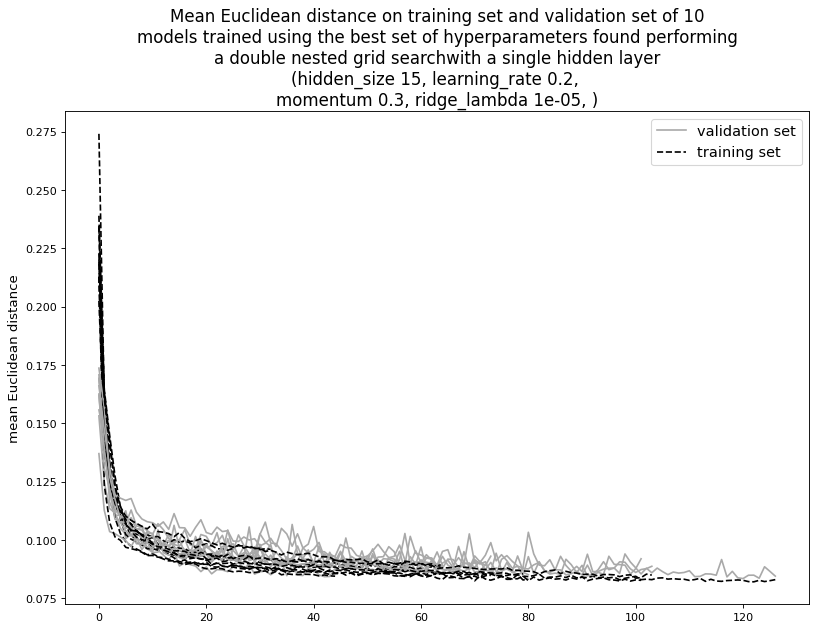

In [31]:
# plot the mean Euclidean distance for the ml cup
plot_mean_euclidean_distance(histories, n_models, best_comb, local_path_plot_ed)

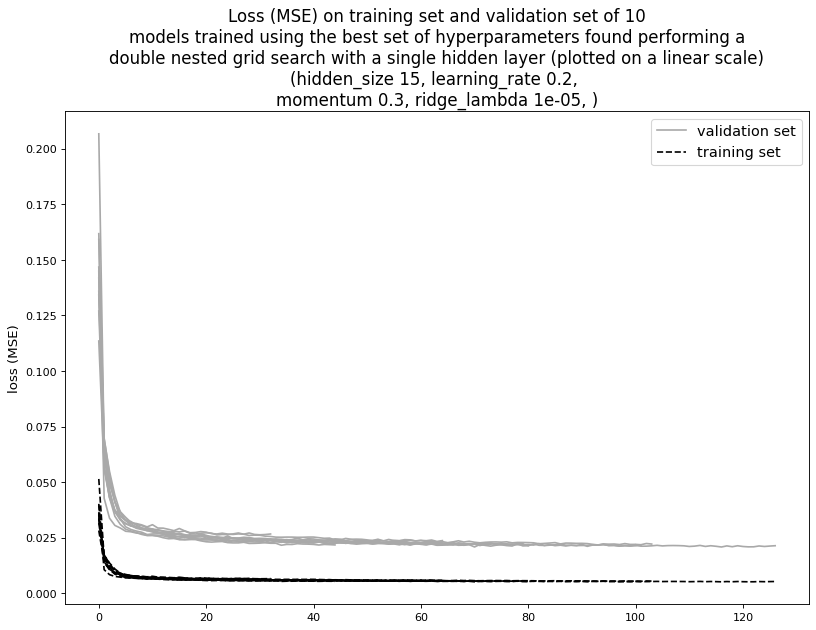

In [32]:
# plot the loss for the ml cup (linear scale)
plot_loss(histories, n_models, best_comb, local_path_plot_loss[0])

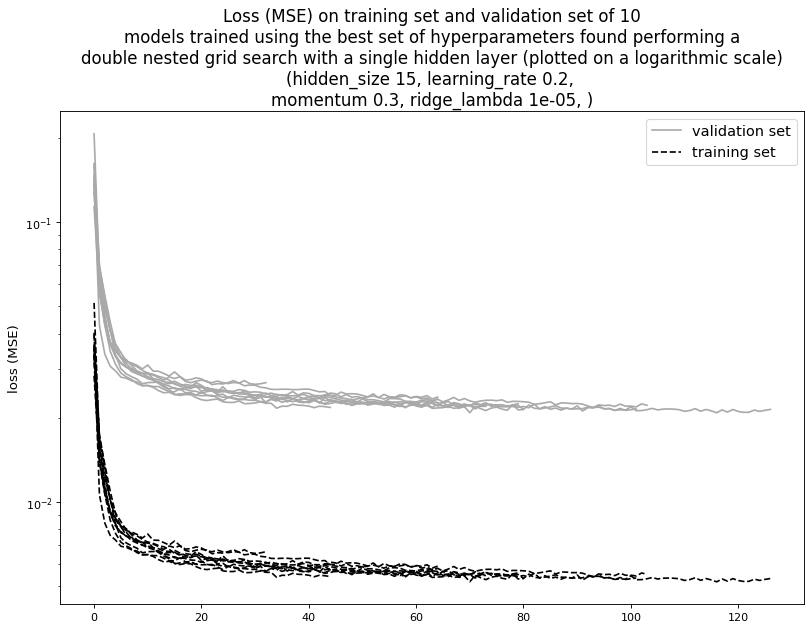

In [33]:
# plot the loss for the ml cup (logarithmic scale)
plot_loss(histories, n_models, best_comb, local_path_plot_loss[1], scale="log")

At this point we are ready to select a final model among those created

In [34]:
# select a model
criterion = "average"
metric = "val_mean_euclidean_distance"
final_model_ml_cup = select_model(models, histories, metric, criterion)

# create a dataloader for the design set
dataloader_design = define_design_dataloader(design_set_cup)

# save the final model
save_model(final_model_ml_cup, local_path_final_model)

# predict the target
pred_target = predict_target_design(final_model_ml_cup, dataloader_design)

final score in the validation set: 0.0886731892824173


let's briefly plot the ditribution of our data (real target vs predicted one)

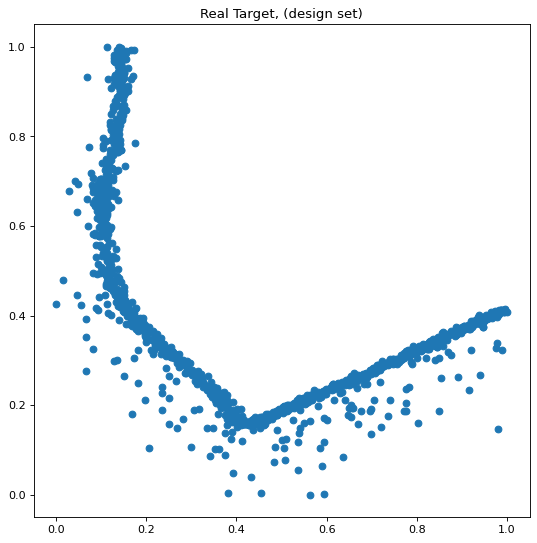

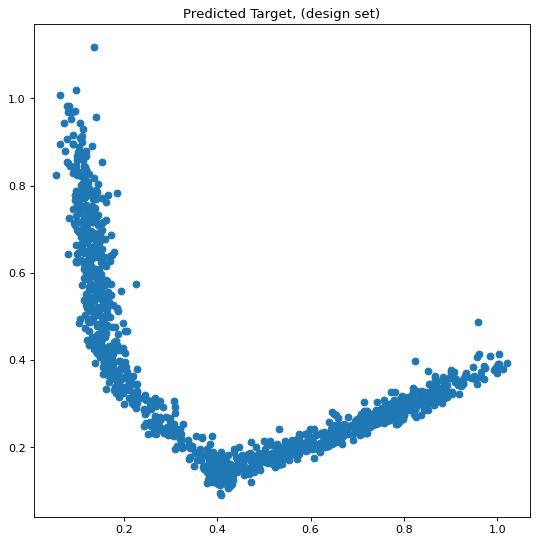

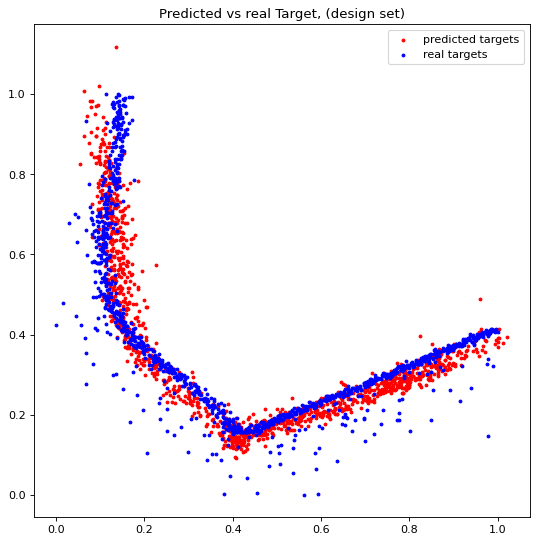

In [35]:
real_target = design_set_cup[:, 9:11]

plot_distr_target(pred_target, real_target, local_path_distr_target)

In conclusion, let's see the final mean Euclidean distance on both training set and validation set (denormalized values)

In [36]:
deNormalized = False

In [37]:
if (not deNormalized):
    
    # prepare data for the training set
    target_tr_set_norm = tr_set[:, 9:11]
    target_tr_set = target_tr_set_norm

    target_tr_set[:, 0] = deNormalizer.deNormalize(target_tr_set[:, 0], 1)
    target_tr_set[:, 1] = deNormalizer.deNormalize(target_tr_set[:, 1], 2)

    dataloader_tr = define_design_dataloader(tr_set)

    pred_target_tr = predict_target_design(final_model_ml_cup, dataloader_tr)

    pred_target_tr[:, 0] = deNormalizer.deNormalize(pred_target_tr[:, 0], 1)
    pred_target_tr[:, 1] = deNormalizer.deNormalize(pred_target_tr[:, 1], 2)
    
    
    # prepare data for the validation set
    target_vl_set_norm = vl_set[:, 9:11]
    target_vl_set = target_vl_set_norm

    target_vl_set[:, 0] = deNormalizer.deNormalize(target_vl_set[:, 0], 1)
    target_vl_set[:, 1] = deNormalizer.deNormalize(target_vl_set[:, 1], 2)

    dataloader_vl = define_design_dataloader(vl_set)

    pred_target_vl = predict_target_design(final_model_ml_cup, dataloader_vl)

    pred_target_vl[:, 0] = deNormalizer.deNormalize(pred_target_vl[:, 0], 1)
    pred_target_vl[:, 1] = deNormalizer.deNormalize(pred_target_vl[:, 1], 2)
    
    deNormalized = True

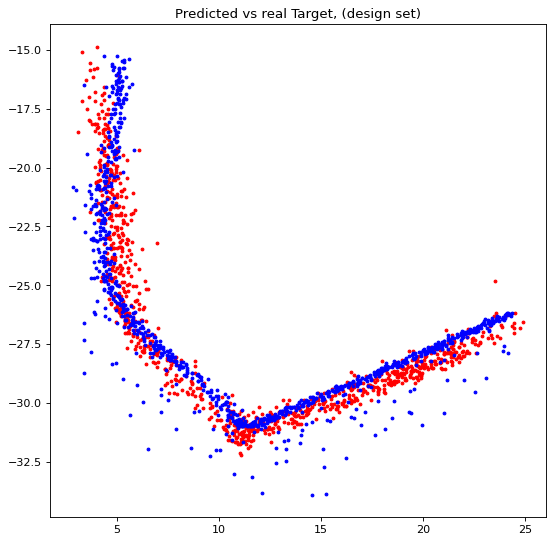

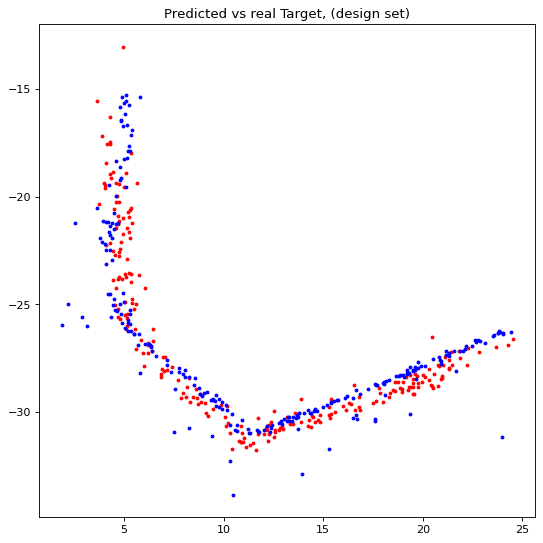

In [38]:
# Briefly printing the plots of the distribution of the training set and validation set separately

marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(pred_target_tr[:, 0], pred_target_tr[:, 1], s=marker_size, c="red")
plt.scatter(target_tr_set[:, 0], target_tr_set[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target, (training set)")
plt.show()

marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(pred_target_vl[:, 0], pred_target_vl[:, 1], s=marker_size, c="red")
plt.scatter(target_vl_set[:, 0], target_vl_set[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target, (validation set)")
plt.show()

In [39]:
res_tr = compute_mean_euclidean_distance(target_tr_set, pred_target_tr)
res_vl = compute_mean_euclidean_distance(target_vl_set, pred_target_vl)

print("final mean Euclidean distance on the training set:", res_tr)
print("final mean Euclidean distance on the validation set:", res_vl)

final mean Euclidean distance on the training set: tensor(1.6860)
final mean Euclidean distance on the validation set: tensor(1.7779)
